# 2. Project: Classification - Titanic ML Challange 

## 1. Defining project Goal 

Creating ML model that classifies Titanic passengers survived or deceased with 80% accuracy.

## 2. Importing Libraries

In [604]:
# Libraries for EDA 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Library for Training model:
from sklearn.linear_model import LogisticRegression

# Libraries for Evaluating Classifiers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Libraries for Cross Validation 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit, StratifiedKFold)
from sklearn.model_selection import cross_val_score 


## 3. Getting Data

In [472]:
# Loading training and test datasets 
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [473]:
# Dimensions of the datasets
df_train.shape, df_test.shape 

((891, 12), (418, 11))

## 4. Explanatory Data Analysis (EDA)

In [474]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 4.1 Missing Data

<AxesSubplot:>

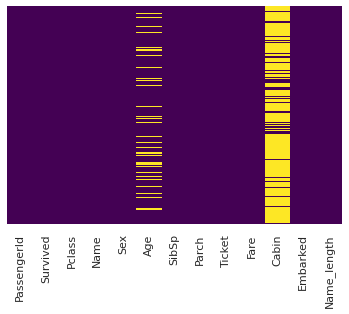

In [624]:
# Creating heatmap to see in which features can be found missing data. 
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [476]:
# is there any missing data in [Age]
df_train[['Age']].isnull().values.any()

True

In [477]:
# the number of missing data in [Age]
df_train['Age'].isnull().sum()

177

In [478]:
# the number of missing data in [Cabin]
df_train['Cabin'].isnull().sum()

687

As we can see, 177/891 observation is NaN in [Age] and 687/891 in [Cabin], therefore I decided not to use this [Cabin] in the model. The missing values of [Age] I will substitute with the Mean value in the step of Feature Engineering with SimpleImputer(). 

The following categorical features does not seem logical to contribute [Ticket, Embarked] to the accuracy of the prediction, therefore I will remove them from the model. 

In [485]:
# in test dataset 1 date is missing from Fare
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Name_length      0
dtype: int64

### 4.2. Transforming ['Name'] 

In [479]:
# length of passenger names was converted into numbers (maybe aristocrats with titles and longer names had a better chance to survive): 
def name_length(df):
    length = df[df.columns[3]].str.len()
    return length.values.reshape(-1, 1)

In [480]:
df_train['Name_length'] = name_length(df_train)

In [481]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24


In [482]:
# Creating Name_lenght column with name_lenght function in test dataset as well
def name_length_df_test(df):
    length = df[df.columns[2]].str.len()
    return length.values.reshape(-1, 1)

In [483]:
df_test['Name_length'] = name_length_df_test(df_test)

In [484]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,16
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,32
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,25
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,16
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,44


### 4.3. Checking Correlations and plotting

In [486]:
# Correlation between Survived and numerical features 
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Name_length
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.012986
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.332350
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.220001
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.034612
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.165019
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.252282
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.155832
Name_length,-0.012986,0.332350,-0.220001,0.034612,0.165019,0.252282,0.155832,1.000000


<AxesSubplot:>

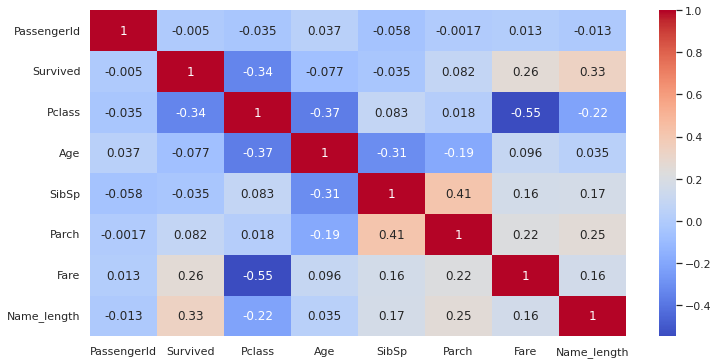

In [623]:
plt.figure(figsize=(12,6)) 
sns.heatmap(df_train.corr(),annot=True, cmap='coolwarm')

The following numerical features show the strongest correlation with [Survived]: 

Pclass: -0.34 	

Fare: 0.26

Name_length: 0.33

<AxesSubplot:xlabel='Age', ylabel='Count'>

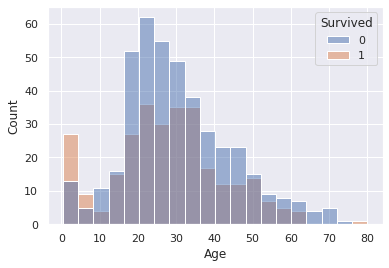

In [487]:
# The histogram shows the age distribution of passengers and compares surviving/non-surviving passengers.
df_train.dropna()
sns.histplot(x='Age', hue='Survived', data=df_train) 

The age distribution shows Passenger under 10 had and over 80 higher probability to survive, between 10-25 and 35-50 much higher probability to decease.

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

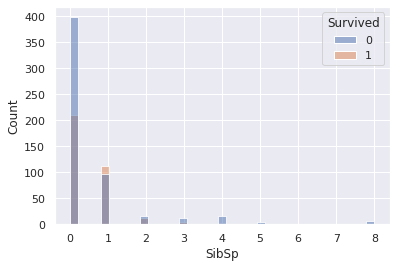

In [488]:
sns.histplot(x='SibSp', hue='Survived', data=df_train) 

<AxesSubplot:xlabel='Parch', ylabel='Count'>

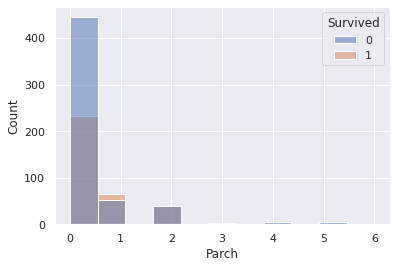

In [489]:
sns.histplot(x='Parch', hue='Survived', data=df_train) 

<AxesSubplot:xlabel='Sex', ylabel='count'>

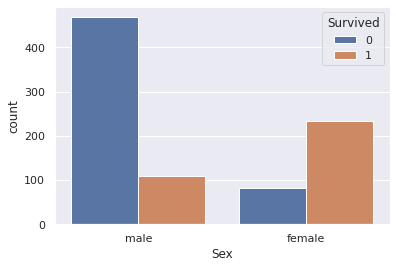

In [490]:
# Plotting charts with relevant categorical features [Sex] and [Survived]
sns.set_theme(style="darkgrid")
sns.countplot(x='Sex', hue='Survived', data=df_train)

According to the barchart there is a correlation between Sex and Survived. Much more male died and much more female survived.

### 4.4 Assigning X and y 

In [578]:
# Keeping the following features in training dataset: Sex, Pclass, Age, SibSp, Fare and Name_lenght. 
# Dropping the rest of the columns. I dropped Parch as well due to an unidentifiable error message.    
X_train = df_train.drop(['Survived','PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Parch'], axis=1)
y_train = df_train['Survived']

In [579]:
X_train.head()

,Pclass,Sex,Age,SibSp,Fare,Name_length
0,3,male,22.0,1,7.2500,23
1,1,female,38.0,1,71.2833,51
2,3,female,26.0,0,7.9250,22
3,1,female,35.0,1,53.1000,44
4,3,male,35.0,0,8.0500,24


In [576]:
# Keeping the following features in test dataset: Sex, Pclass, Age, SibSp, Parch, Fare and Name_lenght. 
X_test = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Parch'], axis=1)

In [577]:
X_test.head()

,Pclass,Sex,Age,SibSp,Fare,Name_length
0,3,male,34.5,0,7.8292,16
1,3,female,47.0,1,7.0000,32
2,2,male,62.0,0,9.6875,25
3,3,male,27.0,0,8.6625,16
4,3,female,22.0,1,12.2875,44


## 5. Feature Engineering

Steps according to Features: 
    
    Pclass: one hot encoding (converting categorical variables into binary features)
    Sex: one hot encoding 
    Age: Imputation (filling missing values) + scaling (normalize the data to the range 0.0 - 1.0)
    SibSp: one hot encoding   
    Fare: Imputation + scaling
    Name_length: scaling
        
Steps according to FE techniques:  

    Imputer: filling missing values in [Age] and [Fare] with mean
    OneHotEncoder: converting categorical variables into numbers in [Pclass], [Sex], [SibSp]
    MinMaxScaler: scale numerical colums in [Age], [Name_length] and [Fare]
    
Since [Age] and [Fare] needs imputation and scaling, I apply pipeline for combining the 2 techniques.  


In [563]:
impute_scale_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
]) 

In [580]:
column_transformer = ColumnTransformer([
    ('impute_scale_pipeline', impute_scale_pipeline, ['Age', 'Fare']),
    ('cat_ohe', OneHotEncoder(), ['Pclass', 'Sex', 'SibSp']),
    ('num_scaler', MinMaxScaler(), ['Name_length'])
])

In [581]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Name_length'], dtype='object')

In [582]:
column_transformer.fit(X_train)
X_train_fe = column_transformer.transform(X_train)
X_test_fe = column_transformer.transform(X_test)

In [583]:
X_train_fe

array([[0.27117366, 0.01415106, 0.        , ..., 0.        , 0.        ,
        0.15714286],
       [0.4722292 , 0.13913574, 1.        , ..., 0.        , 0.        ,
        0.55714286],
       [0.32143755, 0.01546857, 0.        , ..., 0.        , 0.        ,
        0.14285714],
       ...,
       [0.36792055, 0.04577135, 0.        , ..., 0.        , 0.        ,
        0.4       ],
       [0.32143755, 0.0585561 , 1.        , ..., 0.        , 0.        ,
        0.12857143],
       [0.39683338, 0.01512699, 0.        , ..., 0.        , 0.        ,
        0.1       ]])

## 6. Training Model, calculating accuracy score and predict

In [588]:
# train the model using Logistic regression 

LogReg = LogisticRegression()
LogReg.fit(X_train_fe, y_train)

LogisticRegression()

In [592]:
# Evaluating the model 
LogReg.score(X_train_fe, y_train)

0.8047138047138047

In [596]:
# Predicting y value (Survived) of the test dataset 
y_pred = LogReg.predict(X_test_fe)

In [597]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [599]:
# showing the calculated probabilities of the 2 values of the target variable (Survived or deceased) of test dataset
# indicates the likeliness of an observation to belong to each class

LogReg.predict_proba(X_test_fe)

array([[0.92104439, 0.07895561],
       [0.50914738, 0.49085262],
       [0.89127322, 0.10872678],
       [0.90386109, 0.09613891],
       [0.29666724, 0.70333276],
       [0.84811451, 0.15188549],
       [0.44425802, 0.55574198],
       [0.72239426, 0.27760574],
       [0.29358983, 0.70641017],
       [0.89941094, 0.10058906],
       [0.91044461, 0.08955539],
       [0.65459589, 0.34540411],
       [0.05169683, 0.94830317],
       [0.8945274 , 0.1054726 ],
       [0.08745041, 0.91254959],
       [0.13660235, 0.86339765],
       [0.80938425, 0.19061575],
       [0.8865497 , 0.1134503 ],
       [0.38273756, 0.61726244],
       [0.48858734, 0.51141266],
       [0.70419576, 0.29580424],
       [0.83183642, 0.16816358],
       [0.07763356, 0.92236644],
       [0.45202566, 0.54797434],
       [0.08044125, 0.91955875],
       [0.93932108, 0.06067892],
       [0.06831843, 0.93168157],
       [0.89079846, 0.10920154],
       [0.63070205, 0.36929795],
       [0.92632516, 0.07367484],
       [0.

## 7. Cross validation Model Assesment

In [602]:
kf = KFold(n_splits=10, shuffle=True,random_state=42)

In [610]:
cross_accuracy_log = cross_val_score(LogReg, X_train_fe, y_train, cv=10, scoring='accuracy'
)

In [611]:
cross_accuracy_log

array([0.81111111, 0.7752809 , 0.7752809 , 0.82022472, 0.83146067,
       0.79775281, 0.7752809 , 0.7752809 , 0.80898876, 0.78651685])

In [612]:
f"Cross-validation mean {100 * cross_accuracy_log.mean():5.3f} +- {100 * cross_accuracy_log.std():5.3f}"

'Cross-validation mean 79.572 +- 2.013'

In [608]:
cv = cross_validate(LogReg, X_train_fe, y_train,
                    cv=10,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv)


   fit_time  score_time  test_score  train_score
0  0.028013    0.000960    0.811111     0.801498
1  0.028352    0.001013    0.775281     0.802993
2  0.024312    0.000537    0.775281     0.809227
3  0.017641    0.000495    0.820225     0.794264
4  0.016075    0.000503    0.831461     0.804239
5  0.015192    0.000486    0.797753     0.804239
6  0.015826    0.000489    0.775281     0.799252
7  0.014853    0.000486    0.775281     0.806733
8  0.015929    0.000505    0.808989     0.801746
9  0.016511    0.000488    0.786517     0.802993


## 8. Submitting the predictions to Kaggle

In [615]:
predictions = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
predictions.to_csv('predictions3.csv',index=False) 

In [616]:
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
